In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

import numpy as np
from google.colab import drive
import string
import pickle
import tensorflow as tf
import datetime
import os

#from gensim.utils import simple_preprocess

drive.mount('/content/drive')
%matplotlib inline

Mounted at /content/drive


In [3]:
SEED = 42
WORK_DIR = '/content/drive/MyDrive/vologda/'
TR_T_LIM = 4839
LABEL_LIST = ['Релевантность','Таксономия релевантные',
              'Таксономия не релевантные', 'Длина отзыва', 'Ценности']
N_SPLIT=5
#pd.set_option('display.max_colwidth', -1)

In [4]:
'''
!mkdir {WORK_DIR}
!wget https://lodmedia.hb.bizmrg.com/case_files/833457/train_dataset_train.csv
!wget https://lodmedia.hb.bizmrg.com/case_files/833457/test_dataset_test.csv

!cp train_dataset_train.csv {WORK_DIR}
!cp test_dataset_test.csv {WORK_DIR}
'''

'\n!mkdir {WORK_DIR}\n!wget https://lodmedia.hb.bizmrg.com/case_files/833457/train_dataset_train.csv\n!wget https://lodmedia.hb.bizmrg.com/case_files/833457/test_dataset_test.csv\n\n!cp train_dataset_train.csv {WORK_DIR}\n!cp test_dataset_test.csv {WORK_DIR}\n'

# Данные

## первая обработка текстовые фичи gensim preprocess

In [5]:
df_train = pd.read_csv(WORK_DIR+"/train_dataset_train.csv", index_col='RecordNo')
df_test = pd.read_csv(WORK_DIR+"/test_dataset_test.csv", index_col='RecordNo')
TR_T_LIM = len(df_train)
print(TR_T_LIM, len(df_test))
df = pd.concat([df_train, df_test])
df.head(3)

4839 2075


,Название книги,Автор,Ссылка на литрес,Рейтинг,Количество оценок,Количество отзывов,Имя читателя,Оценка книги читателем (из 5 баллов),Отзыв,Лайки на отзыв,Дислайки на отзыв,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
RecordNo,,,,,,,,,,,,,,,,
6145,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.7,3922,408,Айгуль Ляпина,5.0,Рекомендую книгу в прочтению/прослушиванию. Ес...,0,3,0.0,0.0,0.0,0.0,0.0
7006,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.6,24719,2103,Olga T,5.0,"Удивительно, что сейчас возникает ТАКАЯ литера...",0,1,0.0,0.0,0.0,0.0,1.0
1124,Дети мои,Гузель Яхина,https://www.litres.ru/guzel-yahina/deti-moi/,4.4,8032,702,Кирилл Чириков,5.0,"Душевно, жизненно, чувственно, проникновенно!!...",0,0,0.0,1.0,0.0,0.0,1.0


In [6]:
drop_col = ['Ссылка на литрес', ]#'Имя читателя'
df = df.drop(columns=drop_col)

In [7]:
df['Оценка книги читателем (из 5 баллов)'].fillna(df['Оценка книги читателем (из 5 баллов)'].max(), inplace=True) #небольшой косяк можно пережить

cat_col = ['Название книги', 'Автор', 'Имя читателя'] #, 'Оценка книги читателем (из 5 баллов)'
display(df[cat_col].nunique())
for col in cat_col:
    df[col] = df[col].astype('category').cat.codes

df.head(3)

Название книги     106
Автор               61
Имя читателя      5881
dtype: int64

,Название книги,Автор,Рейтинг,Количество оценок,Количество отзывов,Имя читателя,Оценка книги читателем (из 5 баллов),Отзыв,Лайки на отзыв,Дислайки на отзыв,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
RecordNo,,,,,,,,,,,,,,,
6145,41,23,4.7,3922,408,3194,5.0,Рекомендую книгу в прочтению/прослушиванию. Ес...,0,3,0.0,0.0,0.0,0.0,0.0
7006,41,23,4.6,24719,2103,1007,5.0,"Удивительно, что сейчас возникает ТАКАЯ литера...",0,1,0.0,0.0,0.0,0.0,1.0
1124,27,23,4.4,8032,702,4524,5.0,"Душевно, жизненно, чувственно, проникновенно!!...",0,0,0.0,1.0,0.0,0.0,1.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6914 entries, 6145 to 471
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Название книги                        6914 non-null   int8   
 1   Автор                                 6914 non-null   int8   
 2   Рейтинг                               6914 non-null   float64
 3   Количество оценок                     6914 non-null   int64  
 4   Количество отзывов                    6914 non-null   int64  
 5   Имя читателя                          6914 non-null   int16  
 6   Оценка книги читателем (из 5 баллов)  6914 non-null   float64
 7   Отзыв                                 6914 non-null   object 
 8   Лайки на отзыв                        6914 non-null   int64  
 9   Дислайки на отзыв                     6914 non-null   int64  
 10  Релевантность                         4839 non-null   float64
 11  Таксономия реле

In [9]:
def add_text_features(df, col):
    df['char_count'] = df[col].apply(len)
    df['word_count'] = df[col].apply(lambda x: len(x.split()))
    df['word_density'] = df['char_count'] / (df['word_count']+1)
    df['punctuation_count'] = df[col].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
    df['title_word_count'] = df[col].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    df['upper_case_word_count'] = df[col].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    df['excl_count'] = df[col].str.count('!')
    return df

In [10]:
df = add_text_features(df,'Отзыв')

mass_label = ['Релевантность',
       'Таксономия релевантные', 'Таксономия не релевантные',
       'Длина отзыва', 'Ценности']
object_label = list(df.dtypes[df.dtypes == "object"].index.values)
object_label

['Отзыв']

In [11]:
text_features = []
for col in object_label:
    df[col+'_pr']=df[col].apply(lambda x: ' '.join(simple_preprocess(x)))
    text_features.append(col+'_pr')
df[text_features].head(1)

,Отзыв_pr
RecordNo,
6145,рекомендую книгу прочтению прослушиванию есть ...


In [12]:
df.columns

Index(['Название книги', 'Автор', 'Рейтинг', 'Количество оценок',
       'Количество отзывов', 'Имя читателя',
       'Оценка книги читателем (из 5 баллов)', 'Отзыв', 'Лайки на отзыв',
       'Дислайки на отзыв', 'Релевантность', 'Таксономия релевантные',
       'Таксономия не релевантные', 'Длина отзыва', 'Ценности', 'char_count',
       'word_count', 'word_density', 'punctuation_count', 'title_word_count',
       'upper_case_word_count', 'excl_count', 'Отзыв_pr'],
      dtype='object')

In [13]:
with open(WORK_DIR+str(TR_T_LIM)+'.pkl','wb') as f:
    pickle.dump(df,f)

In [20]:
df_tr_val = df[:TR_T_LIM]
df_test = df[TR_T_LIM:]

In [21]:
df_tr_val[mass_label].describe()

,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
count,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000
mean,0.218640,0.512296,0.126886,0.234759,0.542054
std,0.413367,0.499900,0.332879,0.423892,0.498280
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


## анализ

In [36]:
perc = df_tr_val[LABEL_LIST].sum()/len(df_tr_val)
print(perc)
print([int(len(df_test)*i) for i in perc])

print([i/perc[0] for i in perc])
for h in range(400,600,25):
    print([int(h*i/perc[0]) for i in perc])


Релевантность                0.218640
Таксономия релевантные       0.512296
Таксономия не релевантные    0.126886
Длина отзыва                 0.234759
Ценности                     0.542054
dtype: float64
[453, 1063, 263, 487, 1124]
[1.0, 2.343100189035917, 0.5803402646502835, 1.0737240075614367, 2.4792060491493384]
[400, 937, 232, 429, 991]
[425, 995, 246, 456, 1053]
[450, 1054, 261, 483, 1115]
[475, 1112, 275, 510, 1177]
[500, 1171, 290, 536, 1239]
[525, 1230, 304, 563, 1301]
[550, 1288, 319, 590, 1363]
[575, 1347, 333, 617, 1425]


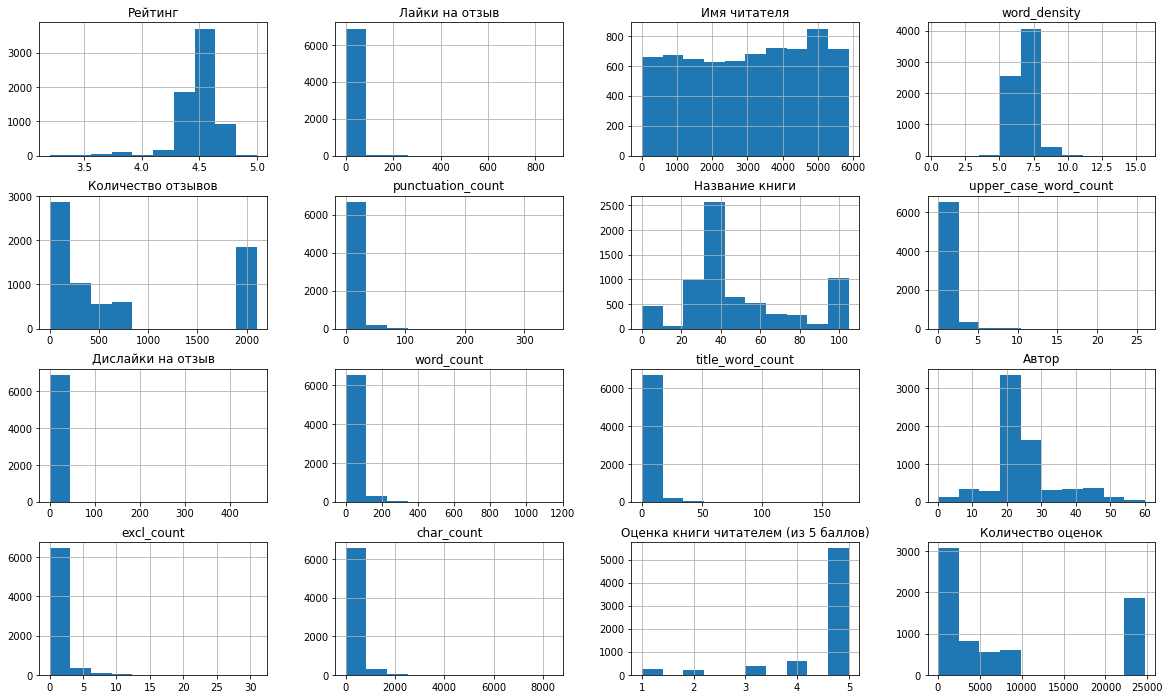

In [38]:
bad_features = ['Отзыв']#, 'title_word_count']#title_word_count косячная фича = word_count, 'Количество оценок', 'Количество отзывов'
features = list(set(list(df.columns))-set(LABEL_LIST)-set(bad_features))
df[features].hist(figsize=(20,12))
# похожи
#df[features].hist(figsize=(20,12))
None

In [39]:
df_tr_val['word_count'].describe()

count    4839.000000
mean       48.793139
std        51.632606
min         1.000000
25%        24.000000
50%        34.000000
75%        55.000000
max       956.000000
Name: word_count, dtype: float64

## загрузка

In [4]:
with open(WORK_DIR+str(TR_T_LIM)+'.pkl','rb') as f:
    df=pickle.load(f)

#df_tr_val = df[:TR_T_LIM]
#df_test = df[TR_T_LIM:]

# в таком виде лучше на2.5%, те word_count bad_features = ['Отзыв']
bad_features = ['Отзыв']#, 'title_word_count']#title_word_count косячная фича = word_count, 'Количество оценок', 'Количество отзывов'
features = list(set(list(df.columns))-set(LABEL_LIST)-set(bad_features))
cat_features = ['Название книги', 'Автор', 'Имя читателя'] #, 'Оценка книги читателем (из 5 баллов)'
#cat_features=[]
text_features = ['Отзыв_pr']
no_text_features = list(set(list(features))-set(text_features))
len(features), len(df.columns), len(df)
#df.head(3)

(17, 23, 6914)

In [5]:
# заменим некоторые фичи на логарифм
#log_features =[feature for feature in  set(no_text_features)-set(cat_features)]
log_features = ['char_count', 'word_count']
new_log_features_cols = ['log_' + feature for feature in log_features]
df[new_log_features_cols] = np.log(df[log_features]+1)

bad_features = bad_features+log_features
features = list(set(list(df.columns))-set(LABEL_LIST)-set(bad_features))
cat_features = ['Название книги', 'Автор', 'Имя читателя'] #, 'Оценка книги читателем (из 5 баллов)'
#cat_features=[]
text_features = ['Отзыв_pr']
no_text_features = list(set(list(features))-set(text_features))

df_tr_val = df[:TR_T_LIM]
df_test = df[TR_T_LIM:]
df_test.head(3)


,Название книги,Автор,Рейтинг,Количество оценок,Количество отзывов,Имя читателя,Оценка книги читателем (из 5 баллов),Отзыв,Лайки на отзыв,Дислайки на отзыв,...,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,excl_count,Отзыв_pr,log_char_count,log_word_count
RecordNo,,,,,,,,,,,,,,,,,,,,,
3366,27,23,4.4,8032,702,4763,5.0,"Настоящая глубокая книга, коих сейчас очень не...",2,0,...,181,30,5.838710,7,3,0,0,настоящая глубокая книга коих сейчас очень нем...,5.204007,3.433987
3952,95,27,4.5,1923,246,1367,5.0,Одна из лучших книг прочитанных за последние г...,1,0,...,219,32,6.636364,6,5,0,0,одна из лучших книг прочитанных за последние г...,5.393628,3.496508
6852,95,27,4.4,7276,622,2002,5.0,"Тот случай, когда невозможно пройти мимо, не о...",0,0,...,390,58,6.610169,19,7,0,2,тот случай когда невозможно пройти мимо не ост...,5.968708,4.077537


# Модели

## catboost

In [6]:
!pip install catboost
##catboost=1.0.6
#catboost=1.1
import catboost as cb
from catboost.utils import eval_metric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.1 MB/s 


In [8]:
# некоторые служебные функции
# факир был пьян и не до конца учел особоенности работы с мультиклассами и
# индексированием разреженых матриц
def cbClassifier(iterations=None, cat_features=cat_features, text_features=text_features):
    tree_params = {
            'iterations': iterations,#None,
            'max_depth': 5,
            'eval_metric': 'Recall',
            'loss_function': 'Logloss',
            #'loss_function': 'MultiCrossEntropy',
            'early_stopping_rounds': 100,
            'random_state': SEED,
            'l2_leaf_reg': 1,
            #'class_names': mass_label,
            'text_features': text_features,
            'cat_features': cat_features
            #diffusion_temperature=None,
            #text_processing=None
        }
    if len(tf.config.list_physical_devices('GPU'))>0:
        tree_params['task_type']='GPU' # если имеется GPU с CUDA, то можно ее задействовать, чтобы на порядок ускорить обучение
    return  cb.CatBoostClassifier(**tree_params)   

def fit_eval(model, train_idx, val_idx, target):
    train, val = df_tr_val.iloc[train_idx], df_tr_val.iloc[val_idx]
    if isinstance(model, cb.CatBoostClassifier):
        train_pool = cb.Pool(train[features], train[target], 
                            cat_features=cat_features, 
                            text_features=text_features
                            )
        val_pool = cb.Pool(val[features], val[target], 
                            cat_features=cat_features,
                            text_features=text_features
                            )

        model.fit(train_pool, eval_set=[val_pool], verbose_eval=50, use_best_model=True, plot=False)
        return model, model.predict_proba(val_pool)
    elif isinstance(model, RandomForestClassifier):
        model.fit(train[no_text_features], 
                  train[target])
        return model, model.predict_proba(val[no_text_features])


def cv(model=cbClassifier, cv_model=KFold, n_splits=10, lab_list=LABEL_LIST):
    cv = cv_model(n_splits=n_splits, random_state=SEED, shuffle=True)
    model_dict, res_dict = dict(), dict()
    for target_col in lab_list:
        print('******************',target_col,'******************')
        model_dict[target_col] = []
        oof = np.zeros(len(df_tr_val))        
        for fold_, (train_idx, val_idx) in enumerate(cv.split(df_tr_val), 1):#, targets
            print(f'Training with fold {fold_} started.')
            mod, res = fit_eval(model(), train_idx, val_idx, [target_col])
            #print(mod.best_score_)
            model_dict[target_col].append(mod)
            oof[val_idx] = res[:, 1]
        res_dict[target_col]=oof
        print('res_dict', len(res_dict[target_col]), oof.shape)
    return model_dict, res_dict #djpdhfoftn 


def get_trhd_dict(lab_list=LABEL_LIST, trhd_list=[.5,.5,.5,.5,.5]):
    trhd_dict = {lab_col:trhd_list[ind] 
                 for ind, lab_col in enumerate(lab_list)}
    #print(trhd_dict)      
    return trhd_dict


def get_model_name(model_dict, res_dict, trhd_dict):
    mod_f_name = f"{datetime.datetime.now():%m%d_%H%M}__"
    print('mod_f_name', type(mod_f_name), mod_f_name)
    for k,mod_list in model_dict.items():
        print(k)
        recall=0
        for mod in mod_list:
            recall+=mod.best_score_['validation']['Recall']
        rec_str = str(round((recall/len(mod_list)),2)).split('.')[-1]
        mod_f_name += rec_str + '_tr'+str(trhd_dict[k]).split('.')[-1]+'_'
        mod_f_name = str(sum(res_dict[k]>trhd_dict[k])) + '_'+mod_f_name
    
    #надо скор вписать в название
        
    mod_f_name+='f'+str(len(mod.feature_names_))+'_'+str(len(mod_list))
    print(mod_f_name)
    return mod_f_name

def get_model_test_prob(model_dict, trhd_dict, lab_list=LABEL_LIST):
    res_dict=dict()
    res_str=''

    test_pool = cb.Pool(df_test[features],# df_test[k], 
            cat_features=cat_features, 
            text_features=text_features
            )

    for lab_col in lab_list:
        mod_list=model_dict[lab_col]
        res_prob=np.zeros(len(df_test))
        best_score = 0
        for model in mod_list:
           res_prob+=model.predict_proba(test_pool)[:,1]
           best_score+= model.best_score_
        res_prob = res_prob/len(mod_list)
        best_score = best_score/len(mod_list)

        res_class=np.array(res_prob>trhd_dict[lab_col],dtype='uint8')
        n_1_trhd = sum(res_class)
        print(lab_col, trhd_dict[lab_col], n_1_trhd)
        res_str += str(trhd_dict[lab_col]).split('.')[-1]+'_'+str(n_1_trhd)+'_'+str(best_score)
        res_dict[lab_col] = [res_prob, res_class]
    return res_dict, res_str
    
def get_col_sum(df, columns=LABEL_LIST):
    res = [str(i)+'_' for i in list(df[columns].sum().astype('int'))]
    return ''.join(res)

def get_trhded_df(df, trhd_dict, model_name, f_save=False):
    res_df=df.copy(deep=True)
    for k,v in trhd_dict.items():
        #display(res_df[k])
        res_df[k]=(res_df[k]>v).astype('int')
        #display(res_df[k])
        #print(get_col_sum(res_df, columns=LABEL_LIST))
        #print('_'.join(list(trhd_dict.values())))
        #print(str(list(trhd_dict.values()))[1:-1]+'_X_'+get_col_sum(res_df, columns=LABEL_LIST))
    #file_name = 'cb_base_log_f_twc_es_'+'_'.join(
    file_name = get_col_sum(res_df, columns=LABEL_LIST)+'_X_'+'_'.join(
        [str(v).split('.')[-1] for v in trhd_dict.values()])+'_'+model_name+'.csv'
    print(file_name)
    if f_save:
        res_df.to_csv(WORK_DIR+'/submits/'+file_name)#, index=False)


#get_model_name(model_dict, res_dict, trhd_dict)

In [13]:
model_dict, res_dict = cv(n_splits=N_SPLIT, lab_list=LABEL_LIST)#[:2])
model_dict['Релевантность'], model_dict.keys()

****************** Релевантность ******************
Training with fold 1 started.
0:	learn: 0.2393868	test: 0.1714286	best: 0.1714286 (0)	total: 42.8ms	remaining: 42.8s
50:	learn: 0.2146226	test: 0.1952381	best: 0.1952381 (40)	total: 1.43s	remaining: 26.7s
100:	learn: 0.2959906	test: 0.2428571	best: 0.2428571 (94)	total: 2.68s	remaining: 23.9s
150:	learn: 0.3419811	test: 0.2857143	best: 0.2857143 (150)	total: 3.9s	remaining: 21.9s
200:	learn: 0.3856132	test: 0.3238095	best: 0.3238095 (181)	total: 5.11s	remaining: 20.3s
250:	learn: 0.4080189	test: 0.3476190	best: 0.3476190 (245)	total: 6.29s	remaining: 18.8s
300:	learn: 0.4209906	test: 0.3428571	best: 0.3476190 (245)	total: 7.47s	remaining: 17.4s
350:	learn: 0.4422170	test: 0.3761905	best: 0.3761905 (342)	total: 8.64s	remaining: 16s
400:	learn: 0.4575472	test: 0.3809524	best: 0.3809524 (352)	total: 9.8s	remaining: 14.6s
450:	learn: 0.4775943	test: 0.3857143	best: 0.3857143 (401)	total: 11s	remaining: 13.4s
500:	learn: 0.4882075	test: 0.

([<catboost.core.CatBoostClassifier at 0x7f572002dcd0>,
 dict_keys(['Релевантность', 'Таксономия релевантные', 'Таксономия не релевантные', 'Длина отзыва', 'Ценности']))

были еще BERT, Ridge, Logreg, RandomForestCl, TFIDF, FastTextSocialNetworkModel но ничего лучшего не показали

In [14]:
res=np.zeros((len(df_test), len(LABEL_LIST)))
print(res.shape)
test_pool = cb.Pool(df_test[features],# df_test[k], 
        cat_features=cat_features, 
        text_features=text_features
        )

for ind, k in enumerate(model_dict.keys()):
    model_list = model_dict[k]
    print(len(model_list))
    #print(res[:,ind])
    for mod in model_list:
        res[:,ind] += mod.predict_proba(test_pool)[:,1]
    print(res[:,ind])
res = res/len(model_list)

#res.sum(res>=.5)
#sum((res>=.5).astype('int'))#.shape
res

(2075, 5)
5
[1.89727952 1.13862288 2.32279589 ... 3.23423091 2.42316235 1.56792272]
5
[1.65363272 4.40335497 0.81073502 ... 4.46288228 4.00477841 2.5760353 ]
5
[0.10677395 0.16465308 0.12226517 ... 0.11068428 0.09873722 0.09538524]
5
[2.66948529 1.92133504 1.6461748  ... 2.61895105 2.16696774 2.75578721]
5
[4.49983922 1.02023646 4.53592228 ... 4.52939891 4.18863112 4.50761702]


array([[0.3794559 , 0.33072654, 0.02135479, 0.53389706, 0.89996784],
       [0.22772458, 0.88067099, 0.03293062, 0.38426701, 0.20404729],
       [0.46455918, 0.162147  , 0.02445303, 0.32923496, 0.90718446],
       ...,
       [0.64684618, 0.89257646, 0.02213686, 0.52379021, 0.90587978],
       [0.48463247, 0.80095568, 0.01974744, 0.43339355, 0.83772622],
       [0.31358454, 0.51520706, 0.01907705, 0.55115744, 0.9015234 ]])

In [15]:
df_test_proba = df_test[LABEL_LIST]# = (res>.5).astype('int')
df_test_proba[LABEL_LIST]=df_test_proba[LABEL_LIST].astype('float')
df_test_proba[LABEL_LIST] = res

file_name = '/proba/cb_base_2log_wc_twc_spl_5_ep_es1000_'+ get_col_sum(
                                            df_test_proba, LABEL_LIST)+'.csv'
print(file_name)
df_test_proba.to_csv(WORK_DIR+file_name)

df_test_proba = pd.read_csv(WORK_DIR+file_name,index_col='RecordNo')

df_test_proba.head(5)

/proba/cb_base_2log_wc_twc_spl_5_ep_es1000_668_1067_288_849_1140_.csv


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
RecordNo,,,,,
3366,0.379456,0.330727,0.021355,0.533897,0.899968
3952,0.227725,0.880671,0.032931,0.384267,0.204047
6852,0.464559,0.162147,0.024453,0.329235,0.907184
4586,0.252172,0.151005,0.023253,0.500593,0.717992
4677,0.250772,0.700260,0.020147,0.373515,0.229633


### Подбор порога

In [15]:
df_test_proba = pd.read_csv(WORK_DIR+'/proba/cb_base_2log_wc_twc_spl_5_ep_es1000_668_1067_288_849_1140_.csv',index_col='RecordNo')
trhd_dict_list = [
                 #get_trhd_dict(trhd_list=[.5,.5,.5,.5,.5]),
                 #get_trhd_dict(trhd_list=[.23,.5,.5,.5,.5]),                  
                 #get_trhd_dict(trhd_list=[.24,.5,.5,.5,.5]),                  
                 #get_trhd_dict(trhd_list=[.25,.5,.5,.5,.5]),                  
                 #get_trhd_dict(trhd_list=[.26,.5,.5,.5,.5]),                                    
                 #get_trhd_dict(trhd_list=[.27,.5,.5,.5,.5]),                  
                 #get_trhd_dict(trhd_list=[.28,.5,.5,.5,.5]),                                    
                 #get_trhd_dict(trhd_list=[.29,.5,.5,.5,.5]),                  
                 get_trhd_dict(trhd_list=[.37, .3,.5,.5,.5]),                                   
                 #get_trhd_dict(trhd_list=[.31,.7,.5,.5,.7]),                  
                 #get_trhd_dict(trhd_list=[.32,.7,.5,.5,.7]),                                    
                 #get_trhd_dict(trhd_list=[.33,.7,.5,.5,.7]),                                    
                 #get_trhd_dict(trhd_list=[.34,.7,.5,.5,.7]),                                                                        
                 #get_trhd_dict(trhd_list=[.35,.7,.5,.5,.7])
                 #get_trhd_dict(trhd_list=[.40,.5,.5,.5,.5]),                  
                 #get_trhd_dict(trhd_list=[.45,.5,.5,.5,.5]),                  
                 ]                  
for trhd_dict in trhd_dict_list:
    get_trhded_df(df_test_proba,trhd_dict,model_name='cb_2log_features_spl_5_ep_es1000',f_save=False)


546_1158_237_419_1085__X_37_3_5_5_5_cb_2log_features_spl_5_ep_es1000.csv


## bert

In [18]:
! git clone https://github.com/balezz/bert4classification.git
! pip install -r bert4classification/requirements.txt
%cd bert4classification
from bert_dataset import CustomDataset
from bert_classifier import BertClassifier

fatal: destination path 'bert4classification' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/bert4classification


Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Downloading:   0%|          | 0.00/241k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch 1/2
Train loss 0.6355846923687457 accuracy 0.7904206175540968
Val loss 0.620474014566575 accuracy 0.8112947658402204
----------
Epoch 2/2
Train loss 0.561288969622953 accuracy 0.8310235837588135
Val loss 0.6599813540842635 accuracy 0.8278236914600551
----------


In [ ]:
classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny',
        tokenizer_path='cointegrated/rubert-tiny',
        n_classes=2,
        epochs=2
)

X_train, X_valid, y_train, y_valid = train_test_split(
        df_tr_val[text_features[0]], df_tr_val[LABEL_LIST[0]], test_size=.15)

classifier.preparation(
        X_train=list(X_train),
        y_train=list(y_train),
        X_valid=list(X_valid),
        y_valid=list(y_valid)
    )
classifier.train()

In [ ]:
%%time
texts = list(df_test[text_features[0]])
labels = list(df_test[LABEL_LIST[0]])

predictions = [classifier.predict(t) for t in texts]
print(predictions)

In [21]:
bert_list=[]
for ind, lab_col in enumerate(LABEL_LIST):
    classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny',
        tokenizer_path='cointegrated/rubert-tiny',
        n_classes=2,
        epochs=3,
        #model_save_path='/content/bert.pt'
    )

    print('********',lab_col,'********')
    X_train, X_valid, y_train, y_valid = train_test_split(
        df_tr_val[text_features[0]], df_tr_val[lab_col], test_size=.01)
    
    #print(list(map(np.shape, [X_train, X_valid, y_train, y_valid])))
    #print(type(X_train))

    classifier.preparation(
            X_train=list(X_train),
            y_train=list(y_train),
            X_valid=list(X_valid),
            y_valid=list(y_valid)
        )
    classifier.train()
    bert_list.append(classifier)
bert_list

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

******** Релевантность ********
Epoch 1/3
Train loss 0.6436542302694771 accuracy 0.7947807933194155
Val loss 0.651159417135641 accuracy 0.8571428571428571
----------
Epoch 2/3
Train loss 0.5860343358464372 accuracy 0.825678496868476
Val loss 0.5634792188648134 accuracy 0.8775510204081632
----------
Epoch 3/3
Train loss 0.546256751478465 accuracy 0.8490605427974949
Val loss 0.5870090792980045 accuracy 0.8775510204081632
----------


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

******** Таксономия релевантные ********
Epoch 1/3
Train loss 0.4308739019497803 accuracy 0.8697286012526096
Val loss 0.5059811940707732 accuracy 0.8775510204081632
----------
Epoch 2/3
Train loss 0.2524721598195722 accuracy 0.9457202505219208
Val loss 0.08639001926640048 accuracy 0.9387755102040816
----------
Epoch 3/3
Train loss 0.17406361617125685 accuracy 0.9640918580375784
Val loss 0.10251512505987194 accuracy 0.9795918367346939
----------


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

******** Таксономия не релевантные ********
Epoch 1/3
Train loss 0.28131126254077105 accuracy 0.9350730688935283
Val loss 0.0011081506754271686 accuracy 0.9999999999999999
----------
Epoch 2/3
Train loss 0.13644062661315998 accuracy 0.97160751565762
Val loss 0.0003309211210580543 accuracy 0.9999999999999999
----------
Epoch 3/3
Train loss 0.08140185689724352 accuracy 0.984133611691023
Val loss 0.00019492429739329965 accuracy 0.9999999999999999
----------


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

******** Длина отзыва ********
Epoch 1/3
Train loss 0.6485957942398495 accuracy 0.7862212943632568
Val loss 0.4880902683362365 accuracy 0.8163265306122448
----------
Epoch 2/3
Train loss 0.625521685813927 accuracy 0.8121085594989562
Val loss 0.5551919224951416 accuracy 0.8571428571428571
----------
Epoch 3/3
Train loss 0.5935836162664568 accuracy 0.8325678496868476
Val loss 0.5925276495236903 accuracy 0.836734693877551
----------


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

******** Ценности ********
Epoch 1/3
Train loss 0.5843385956320369 accuracy 0.8127348643006264
Val loss 0.5615483035554644 accuracy 0.8571428571428571
----------
Epoch 2/3
Train loss 0.4232235476084074 accuracy 0.892275574112735
Val loss 0.5364076248242055 accuracy 0.8775510204081632
----------
Epoch 3/3
Train loss 0.3391797897733234 accuracy 0.9194154488517746
Val loss 0.6690630360593787 accuracy 0.8571428571428571
----------


In [22]:
preds = dict()
for ind, lab_col in enumerate(LABEL_LIST):
    preds[lab_col] = [bert_list[ind].predict(t) for t in list(df_test['Отзыв_pr'])]
preds.keys()

res_str=''
for k in preds.keys():
    res_str+=str(sum(preds[k]))+'_'
    df_test[k] = preds[k]
res_path=WORK_DIR+'submits/221004_'+res_str+'X__bert.csv'
df_test[LABEL_LIST].to_csv(res_path)
res_path

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


'/content/drive/MyDrive/vologda/submits/221004_373_987_223_239_1015_X__bert.csv'

## Блендинг

In [11]:
#res_bert = '/content/drive/MyDrive/vologda/submits/221004_373_987_223_239_1015_X__bert.csv'
df_best = pd.read_csv(WORK_DIR+'/submits/checked/best.csv', index_col='RecordNo')#8655
last_name = '221004_373_987_223_239_1015_X__bert.csv'

df_last = pd.read_csv(WORK_DIR+'/submits/'+last_name, index_col='RecordNo')
display(df_last.head(3))

mix_df = df_best.copy(deep=True)
mix_df[LABEL_LIST] = (df_best[LABEL_LIST]+df_last[LABEL_LIST])/2
mix_df_high = (mix_df>=.5).astype(int)
mix_df_high.to_csv(WORK_DIR+'/submits/mh_bert'+get_col_sum(mix_df_high)+last_name)
#mix_df_low = (mix_df>.5).astype(int)
#mix_df_low.to_csv(WORK_DIR+'/submits/ml_tfidf_4col_'+get_col_sum(mix_df_low)+last_name)
#get_col_sum(mix_df_high)
print(WORK_DIR+'/submits/mh_bert'+get_col_sum(mix_df_high)+last_name)

,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
RecordNo,,,,,
3366,0,0,0,1,1
3952,0,1,0,0,0
6852,0,0,0,0,1


/content/drive/MyDrive/vologda//submits/mh_bert583_1018_253_651_1096_221004_373_987_223_239_1015_X__bert.csv
